In [1]:
from langchain_groq import ChatGroq
import os 
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(
    temperature=0,
    groq_api_key = os.environ['GROQ_KEY'],
    model_name="llama-3.3-70b-versatile"
)

# result = llm.invoke("What is Langgraph?")
# print(result.content)

In [2]:
from pydantic import BaseModel, Field
from typing import List
from typing_extensions import TypedDict

class Question(BaseModel):
    question: str = Field(
        question="The question asked by the examiner",
    )
    @property
    def qn(self) -> str:
        return f"Question: {self.question}\n"

class Perspectives(BaseModel):
    questions: List[Question] = Field(
        description="List of questions asked by the examiner",
    )

class GenerateQuestionsState(TypedDict):
    grade: str # Grade that examiner teaches
    subject: str # Subject that examiner teaches
    max_questions: int # Number of questions
    human_feedback: str # Human feedback
    questions: List[Question] # Questions asked by examiner

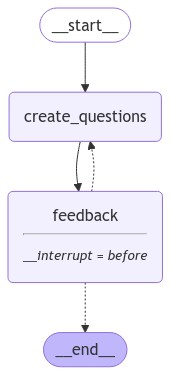

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

examiner_instructions="""You are an examiner tasked with creating questions that will have detailed answers. Follow these instructions carefully:

1. First, get the grade that the examiner teaches:
{grade}
        
1. Then, get the subject that the examiner teaches:
{subject}

2. Examine any feedback given to guide the creation of questions: 
        
{human_feedback}
    
3. Determine the questions appropriate for the grade and subject and consider human feedback if any.
                    
4. Return the top {max_questions} questions."""

def create_questions(state: GenerateQuestionsState):
    
    grade=state['grade']
    subject=state['subject']
    max_questions=state['max_questions']
    human_feedback=state.get('human_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = examiner_instructions.format(grade=grade,
                                                  subject=subject,
                                                  human_feedback=human_feedback, 
                                                  max_questions=max_questions)

    # Generate question 
    questions = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of questions.")])
    
    # Write the list of questionss to state
    return {"questions": questions.questions}

def feedback(state: GenerateQuestionsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateQuestionsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_questions"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateQuestionsState)
builder.add_node("create_questions", create_questions)
builder.add_node("feedback", feedback)
builder.add_edge(START, "create_questions")
builder.add_edge("create_questions", "feedback")
builder.add_conditional_edges("feedback", should_continue, ["create_questions", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
grade = "8th"
subject = "history"
max_questions = 3
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question{idx}: {question.question}")
            print("-" * 50)  

Question0: What were the main causes of the American Revolution?
--------------------------------------------------
Question1: How did the Industrial Revolution impact society in the 18th and 19th centuries?
--------------------------------------------------
Question2: What were the key factors that led to the rise and fall of the Roman Empire?
--------------------------------------------------


In [5]:
state = graph.get_state(thread)
state.next

('feedback',)

In [6]:
graph.update_state(thread, {"human_feedback": 
                            "Add a question related to Prussia"}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda289-e2b4-608b-8002-0929a5cbe374'}}

In [7]:
for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question{idx}: {question.question}")
            print("-" * 50)  

Question0: What were the main causes of the American Revolution?
--------------------------------------------------
Question1: How did the Industrial Revolution impact society in the 18th and 19th centuries?
--------------------------------------------------
Question2: What were the key factors that led to the rise and fall of the Roman Empire?
--------------------------------------------------
Question0: What were the main factors that led to the rise of Prussia as a major power in 18th century Europe?
--------------------------------------------------
Question1: How did the Congress of Vienna in 1815 affect the territorial boundaries of Prussia?
--------------------------------------------------
Question2: What role did Otto von Bismarck play in the unification of Germany, and how did Prussia benefit from this unification?
--------------------------------------------------
